In [1]:
import numpy as np


In [26]:
import modules.experiment.events as expevents
import modules.eas_reconstruction as eas
import modules.utils as utils
import modules.mcmc as mcmc

import modules.plots.eas as easplots

from modules_reloader import reloader

relmod = reloader(expevents, eas, easplots, utils, mcmc)

In [3]:
relmod()

In [4]:
processor = expevents.EventProcessor(N=45, verbosity=3, load_rir=False)
L = 10
N = processor.N

In [5]:
event_id = 10675
event = expevents.Event(event_id)

min_significance = 4
acceptable_plane_jitter = 0.1  # degrees

In [6]:
x_fov, y_fov, t_means, t_stds = eas.get_arrival_times(event, processor, min_signal_significance=min_significance)
print(f'{len(x_fov)} points with significance>{min_significance}')

popt, perr, in_fit_mask = eas.adaptive_excluding_fit(
    x_fov, y_fov, t_means, t_stds, acceptable_angle_between=acceptable_plane_jitter, absolute_distance_exclusion=True
)

print(f'{np.sum(in_fit_mask)} points left in fit after exclusion')

45 points with significance>4
35 points left in fit after exclusion


In [7]:
x_fov, y_fov, n_means, n_stds = eas.get_data_on_plane(event, processor, parameter='n', min_signal_significance=min_significance)

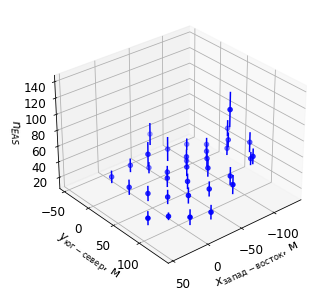

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from modules.plots._shared import Figsize

fig = plt.figure(figsize=Figsize.NORMAL.value)
ax = fig.add_subplot(111, projection='3d')

easplots.plot_scatter_with_errorbars(
    ax, x_fov, y_fov, n_means, n_stds,
    masks=[in_fit_mask],
    markers=['o'],
    colors=['b'],
    ylabel='$n_{{EAS}}$',
)


In [57]:
from numba import njit

In [69]:
def get_axis_position_logprior_and_loglike(x, y, n_mean, n_std):
    ch_x_y = np.concatenate((np.expand_dims(x, 1), np.expand_dims(y, 1)), axis=1)

    max_ch_r = np.max(np.sqrt(np.sum(ch_x_y ** 2, axis=1)))

    n_disp = n_std ** 2
    N_pts = len(x)

    @njit
    def logprior(ax_x_y):
        r = np.sqrt(np.sum(ax_x_y ** 2))
        return 0 if r < 3 * max_ch_r else -np.inf

    @njit
    def loglike(ax_x_y):
        r = np.sqrt(np.sum((ch_x_y - ax_x_y) ** 2, axis=1))
        sort_is = np.argsort(r)  # sorting from shower axis to the side
        r = r[sort_is]
        n_mean_ = n_mean[sort_is]
        n_disp_ = n_disp[sort_is]

        def is_greater_prob(i, j):  # P(i>j)
            mu = n_mean_[i] - n_mean_[j]
            sigma = np.sqrt(n_disp_[i] + n_disp_[j])
            return 1 - utils.norm_cdf(np.array([0.0]), mu=mu, sigma=sigma)
        
        logp = 0.0
        for i in range(N_pts):
            for j in range(i + 1, N_pts):
                logp += np.log(is_greater_prob(i, j))[0]

        return logp

    return logprior, loglike

In [70]:
logprior, loglike = get_axis_position_logprior_and_loglike(*utils.apply_mask(x_fov, y_fov, n_means, n_stds, mask=in_fit_mask))

In [71]:
def logposterior(ax):
    logp = logprior(ax)
    return logp if np.isinf(logp) else logp + loglike(ax)

In [72]:
n_walkers = 512

In [73]:
i_max_ch = np.argmax(n_means[in_fit_mask])
max_ch_xy = np.array([x_fov[in_fit_mask][i_max_ch], y_fov[in_fit_mask][i_max_ch]]).reshape(1, 2)

sigma_estimation = 3
init_point = np.tile(max_ch_xy, (n_walkers, 1)) + np.random.normal(scale=sigma_estimation, size=(n_walkers, 2))

In [74]:
tau = 200

In [75]:
result = mcmc.run_mcmc(
    logposterior=logposterior,
    init_point=init_point,
    config=mcmc.SamplingConfig(
        n_walkers=n_walkers,
        n_samples=10 * tau,
        starting_points_strategy='given',
        progress_bar=True,
        autocorr_estimation_each=500,
        debug_acceptance_fraction_each=1000,
    ),
)

 50%|█████     | 1000/2000 [02:09<02:02,  8.17it/s]
 Current acc. frac.:0.443
100%|██████████| 2000/2000 [04:21<00:00,  7.32it/s]
 Current acc. frac.:0.45
100%|██████████| 2000/2000 [04:21<00:00,  7.64it/s]


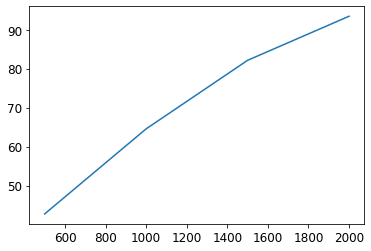

In [76]:
plt.plot(*result.N_tau)

In [84]:
axis_xy_sample = mcmc.extract_independent_sample(result.sampler, tau_override=tau, debug=True)

Autocorrelation time is estimated at 200.0 (ranges from 200 to 200)
Burn-in = 400 samples
Thinning = 180 samples


In [88]:
i_max_in_sample = np.argmax(np.array([loglike(axis_xy) for axis_xy in axis_xy_sample]))

print(axis_xy_sample[i_max_in_sample, :])

[-93.73176508  89.65024845]


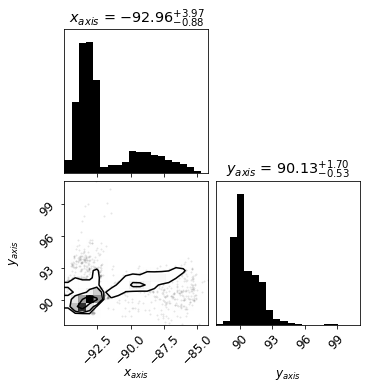

In [85]:
from corner import corner
import matplotlib.pyplot as plt

corner(
    axis_xy_sample,
    labels=['$x_{{axis}}$', '$y_{{axis}}$'],
    show_titles=True,
    bins=20,
    plot_contours=True,
    hist_kwargs={
        'histtype': 'bar',
    },
)

plt.show()